## Introduction
In this assignment we will import data from the San Francisco airport and create a dataset that allows us to perform some summary statistics on the customers' experience with the airport and generate a list of customers that we will target for a 2017 follow up focus group.

The code below assumes that you are running this Notebook from the folder you unzipped the .zip package containing the datafiles and other assets as needed to run thes scripts.


## Part 1
Part 1:  Import the data and create a single data frame containing key fields on survey responses for further analysis.
(a) List the the variables from each year that you used to create this data set using the original names they had in the data set they appeared in.

(b) Document any variable name changes so that it's clear what the original variables are whose names you changed. (Otherwise, a user of your data wouldn't be able to know what these variables are, or how to use them.)

(c) Describe your DataFrame in terms of its size, the variables in it, and how the data types of the variables. How many missing values do you have on the ratings variables?

(d) Write your new DataFrame to a csv file with an initial header record that includes the variable names. Verify that you wrote this file without errors.


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import pickle

sfo_2016 = pd.read_csv("SFO_2016.csv", parse_dates=True)
sfo_2015 = pd.read_csv("SFO_2015.csv", parse_dates=True)
sfo_2014 = pd.read_csv("SFO_2014.csv", parse_dates=True)

C:\Users\Jeff\Anaconda3\lib\site-packages\matplotlib\__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


We'll create some profiling reports using the pandas_profiling just to get a sense for what's in each of these data sets.  Some manual analysis and comparison between them is required, then we will select the columns that we need for all the parts of the assignment below and combine them all into a single dataset.  Some columns may need to be renamed, some values may need to be rekeyed for year to year consistency, and we'll need to handle missing or otherwise incorrect values.

In [6]:
pandas_profiling.ProfileReport(df=sfo_2014)

In [8]:
pandas_profiling.ProfileReport(df=sfo_2015)

In [9]:
pandas_profiling.ProfileReport(df=sfo_2016)

This image shows the columns that we have selected that should satisfy the requirements for Part 1 and the subesequent parts below.  We have a single dataframe that we can then manipulate to create subsets that will be needed for analyzing comments, demographic data, and creating a targeting list for 2017 follow up surveys.

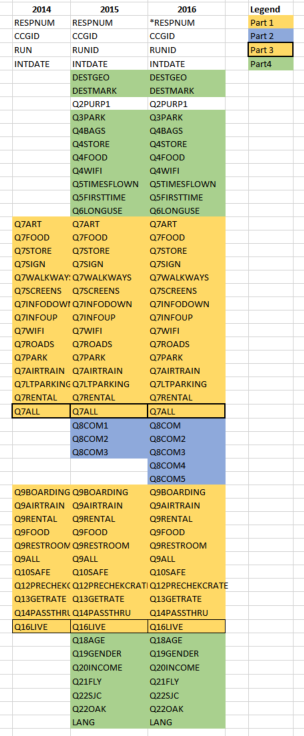

Now, we will do some cleanup that will be needed to create a union of all three years' with the columns we need for ech part of the assignment. We'll make it easy on ourselves now by doing the minimal amount of cleanup needed.  As we go, we may find things we need to clean up, as noted int he pandas_profiling reports.  Several fields have missing values, and there are a number of key columns that reference data supplied by the data dictionary.  Ideally, we'd have tables that supplied the key-value pairs for the coded columns.  We will add those as we go if needed.

Once this initial cleansing step is complete, the columns needed for Part 1 are extracted and a new dataframe is created containing the ratings data for key airport amenities and the airport overall.  Finally, the new dataframe is output to a .csv and a pickle file for reuse later.


In [2]:
#Fix column names that need adjusting
sfo_2016 = sfo_2016.rename(index=str,columns={"*RESPNUM": "RESPNUM"})

#Add a Year column to each
sfo_2016['Year'] = 2016
sfo_2015['Year'] = 2015
sfo_2014['Year'] = 2014


#Append the files together with the common fields needed for Parts 2-4 into a Pandas dataframe
sfo_all = pd.concat([sfo_2014,sfo_2015,sfo_2016],ignore_index=True)

cols_part1 = ('RESPNUM','Year','CCGID','RUNID','INTDATE',
              'Q7ART','Q7FOOD','Q7STORE','Q7SIGN',
              'Q7WALKWAYS','Q7SCREENS','Q7INFODOWN',
              'Q7INFOUP','Q7WIFI','Q7ROADS','Q7PARK',
              'Q7AIRTRAIN','Q7LTPARKING','Q7RENTAL','Q7ALL',
              'Q9BOARDING','Q9AIRTRAIN','Q9RENTAL','Q9FOOD',
              'Q9RESTROOM','Q9ALL','Q10SAFE','Q12PRECHEKCRATE',
              'Q13GETRATE','Q14PASSTHRU','Q16LIVE')

sfo_part1 = pd.DataFrame(data=sfo_all,columns=cols_part1)

#c. profile new dataframe
#run the profiling and discuss

#d write to a new .csv file with initial header; reimport and check values
sfo_part1.to_csv("SFO_PART1.csv",header=True,index=True)

#test 
sfo_part1_test = pd.read_csv("SFO_PART1.csv",parse_dates=True)


Part 2: In this section, we analyze the comments data to determine the top 3 comments for 2015 and 2016. For each year, there are multiple columns for comments, presumably so the customer could add more than one piece of feedback.  We will 'union' all of the columns for each year, then summarize and count the number of instances for each comment.

The comments in these fields are actually IDs, that map to text in a large dictionary in the provided documentation.  Once we have aggregated the total instances of each comment ID, we will look up the values and provide a lookup table to provide the text of the comments ranked by the percent of total comments for each year.

In [4]:
# Part 2: Identify the top three comments made in 2015 and 2016
# Create a Comments dataset based on the information from the Data Dictionary for the comment codes
# 
sfo_part2 = sfo_all['Year'] >= 2015
sfo_part2 = sfo_all[sfo_part2]
cols_part2 = ('Q8COM1','Q8COM2','Q8COM3','Q8COM4','Q8COM5')
sfo_part2 = pd.DataFrame(data=sfo_part2,columns=cols_part2)

comments = []
for col in cols_part2:
    s = pd.Series(sfo_part2[col])
    s = s.dropna()
    comments.append(s)

comments = pd.concat(comments)
comments = pd.DataFrame(comments)
comments = comments.rename(columns={0:'CommentCode'})
comments['Count'] = 1
comments['CommentCode'] = comments.loc[:,('CommentCode')].astype('category')
comments = comments.pivot_table(values='Count',index='CommentCode',aggfunc=sum)
comments['TotalComments']=comments.Count.sum()
comments['Prop']=comments.Count/comments.TotalComments

top5comments = comments.sort_values(by='Count', ascending=False).head(5)

print(top5comments)

             Count  TotalComments      Prop
CommentCode                                
999.0          192           2389  0.080368
202.0          186           2389  0.077857
505.0          102           2389  0.042696
203.0           72           2389  0.030138
501.0           70           2389  0.029301


Part 3:  Summarize the Q7ALL data by Home residence location.  We will create a "lookup table" to provide a meaningful desription for the location codes in the HOME field.  Looking at the data dictionary for home residence location (field named "HOME"), the codes are all the same, so we can analyze the Q7ALL field by location.

We can take the frequencies of each response to the question in Q7ALL, "Rating SFO Airport as a whole", analyze the mean and variance for those providing a response (we will ignore responses other than a 1-5 on this question).  Fortunatley, only 3.7% of respondents didn't answer this question in 2015, and in 2016 the percent blank was only2.4%.

In [20]:
#Part 3:  Analyze the Q7ALL "SFO Rating as a whole" question by residence Home location

#set the columns
cols_part3 = ('RESPNUM','Year','RUNID','HOME','Q7ALL')

sfo_part3 = pd.DataFrame(data=sfo_all,columns=cols_part3)
sfo_part3 = sfo_part3.dropna()

#for some reason, probably the javascript in the browser, need to convert Q7ALL to a float to get the statistics
sfo_part3['Q7ALL'] = sfo_part3['Q7ALL'].astype(float)
#only use the ratings between 1 and 5; 0 = no answer, 6= no experience, we only want the people who had an opinion

sfo_part3 = sfo_part3[(sfo_part3.Q7ALL > int(0)) & (sfo_part3.Q7ALL < int(6))]
print(sfo_part3.dtypes)

sfo_part3_summary = sfo_part3.groupby(['Year','HOME'])

part3_stats = sfo_part3_summary['Q7ALL'].describe()
print(part3_stats)


RESPNUM    float64
Year         int64
RUNID      float64
HOME       float64
Q7ALL      float64
dtype: object
           count      mean       std  min   25%  50%   75%  max
Year HOME                                                      
2015 1.0   264.0  4.041667  0.677003  2.0  4.00  4.0  4.00  5.0
     2.0   159.0  4.113208  0.746139  2.0  4.00  4.0  5.00  5.0
     3.0   147.0  4.129252  0.733467  1.0  4.00  4.0  5.00  5.0
     4.0   134.0  4.126866  0.630332  2.0  4.00  4.0  5.00  5.0
     5.0   114.0  4.087719  0.759150  2.0  4.00  4.0  5.00  5.0
     6.0    55.0  4.236364  0.637229  3.0  4.00  4.0  5.00  5.0
     7.0    39.0  4.025641  0.668351  2.0  4.00  4.0  4.00  5.0
     8.0    12.0  4.333333  0.492366  4.0  4.00  4.0  5.00  5.0
     9.0    13.0  4.153846  0.554700  3.0  4.00  4.0  4.00  5.0
     10.0  658.0  4.051672  0.744583  1.0  4.00  4.0  5.00  5.0
     11.0  299.0  4.066890  0.701538  2.0  4.00  4.0  5.00  5.0
     12.0  367.0  4.019074  0.722145  1.0  4.00  4.0  5.00 

Part 4:  a) We will import the targeting dataset and join with a copy of our original dataset with just the years 2015 and 2016 to create a dataframe that consists of the following:
        •Respondent ID
        •Year surveyed
        •Destination geographic area
        •Size of destination market
        •Purpose(s) of travel (Make sure that the meanings of the codes are consistent, e.g. that a code of "5" means the same thing year to year.)
        •Used parking?
        •Checked baggage?
        •Purchased from a store?
        •Purchased in a restaurant?
        •Used free WiFi?
        •Times Flown in last 12 mo.
        •First time flying out of SFO?
        •How Long Using SFO?
        •Residence Location? Bay Area, or ...? (Q16LIVE)
        •Age
        •Gender
        •Income
        •Fly 100K miles or more per year?
        •Language version of questionnaire
        •Have used the San Jose airport
        •Have used the Oakland airport
b) SAve the file as a headered .csv file and profile the results ensuring good data quality
(c) Tabulate the frequencies of the codes for Parking, Times Flown, Gender, How Long Using SFO. Account for missing values.

Part 5: Pickleize all the data frames for use in a later session.  
 

In [25]:
#Part 4:  Create a targeting dataset
#Import the targeting data


select_resps_2017 = pd.read_csv("select_resps_2017.csv",parse_dates=True)
cols_part4_resps = ('RESPNUM','year')
select_resps_2017 = pd.DataFrame(data=select_resps_2017,columns=cols_part4_resps)
select_resps_2017 = select_resps_2017.rename(columns={"year" : "Year"})

cols_part4_demos = ('RESPNUM','Year','DESTGEO','DESTMARK','Q3PARK','Q4BAGS',
                    'Q4STORE','Q4FOOD','Q4WIFI','Q5TIMESFLOWN','Q5FIRSTTIME',
                    'Q6LONGUSE','Q18AGE','Q19GENDER','Q20INCOME','Q21FLY',
                    'Q22SJC','Q22OAK','LANG')
sfo_all['Year'] = sfo_all['Year'].astype(int)
part4_demos = sfo_all[(sfo_all.Year >=2015)]
part4_demos=pd.DataFrame(data=part4_demos,columns=cols_part4_demos)

#we'll fill the na values ()
part4_demos = part4_demos.fillna(-1)


part4_targeting = pd.merge(select_resps_2017, part4_demos, how='inner', on=['RESPNUM', 'Year'])
print(part4_targeting.head(5))


  RESPNUM  Year  DESTGEO  DESTMARK Q3PARK  Q4BAGS  Q4STORE  Q4FOOD  Q4WIFI  \
0    1054  2016      2.0       3.0      4     1.0      2.0     1.0     1.0   
1    1088  2016      2.0       2.0     -1     2.0      2.0     2.0     1.0   
2    1952  2016      8.0       4.0     -1     1.0      1.0     2.0     2.0   
3     794  2016      4.0       1.0     -1     1.0      2.0     2.0     2.0   
4     406  2016      2.0       4.0     -1     1.0      0.0     1.0     1.0   

   Q5TIMESFLOWN  Q5FIRSTTIME  Q6LONGUSE  Q18AGE  Q19GENDER  Q20INCOME  Q21FLY  \
0           2.0          1.0        4.0    -1.0       -1.0       -1.0    -1.0   
1           5.0          1.0        4.0    -1.0       -1.0       -1.0    -1.0   
2           2.0          1.0        4.0    -1.0       -1.0       -1.0    -1.0   
3           2.0          1.0        2.0    -1.0       -1.0       -1.0    -1.0   
4           2.0          1.0        4.0    -1.0       -1.0       -1.0    -1.0   

   Q22SJC  Q22OAK  LANG  
0    -1.0    -1.0 